In [2]:
%load_ext autoreload
%autoreload 2

import sys
sys.path.append('..')  # enable import from src/

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [21]:
import pickle
from copy import deepcopy
from pathlib import Path

import gurobipy
from gurobipy import GRB
import dgl
import numpy as np
import torch
import matplotlib.pyplot as plt

from src.data import get_model, get_soc, load_instance
from src.dataset import InstanceEarlyFixingDataset
from src.net import InstanceGCN
from src.utils import load_from_wandb

In [31]:
instances = list(Path('../data/raw').glob('97_9*.jl'))[-2:]  # test instances only

with open('../97_9_opts.pkl', 'rb') as f:
    opts = pickle.load(f)

net = InstanceGCN(2, readout_op=None)
net = load_from_wandb(net, 'f6ceqpse', 'sat-gnn', 'model_best')
net.eval()

opts = [opts[i.name]['sol'] for i in instances]
ds = InstanceEarlyFixingDataset(
    [load_instance(i) for i in instances],
    opts,
    samples_per_problem=10,
)
g1 = ds.gs[0]
g2 = ds.gs[1]

x1_opt = torch.from_numpy(opts[0])
x2_opt = torch.from_numpy(opts[1])

g1, g2

(Graph(num_nodes={'con': 5260, 'soc': 96, 'var': 1746},
       num_edges={('con', 'c2s', 'soc'): 191, ('con', 'c2v', 'var'): 61755, ('soc', 's2c', 'con'): 191, ('var', 'v2c', 'con'): 61755},
       metagraph=[('con', 'soc', 'c2s'), ('con', 'var', 'c2v'), ('soc', 'con', 's2c'), ('var', 'con', 'v2c')]),
 Graph(num_nodes={'con': 5429, 'soc': 96, 'var': 1746},
       num_edges={('con', 'c2s', 'soc'): 191, ('con', 'c2v', 'var'): 51457, ('soc', 's2c', 'con'): 191, ('var', 'v2c', 'con'): 51457},
       metagraph=[('con', 'soc', 'c2s'), ('con', 'var', 'c2v'), ('soc', 'con', 's2c'), ('var', 'con', 'v2c')]))

In [35]:
instances

[PosixPath('../data/raw/97_9.jl'), PosixPath('../data/raw/97_9_2.jl')]

In [24]:
def create_batch(g, xs):
    g_batch = list()
    for x in xs:
        g_ = deepcopy(g)
        curr_feats = g_.nodes['var'].data['x']
        g_.nodes['var'].data['x'] = torch.hstack((
            # unsqueeze features dimension, if necessary
            curr_feats.view(curr_feats.shape[0],-1),
            x.view(x.shape[-1],-1),
        ))
        g_batch.append(g_)
    return dgl.batch(g_batch)

x1s = torch.randint(0, 2, (10, 1746))
g1_batch = create_batch(g1, x1s)

x2s = torch.randint(0, 2, (10, 1746))
g2_batch = create_batch(g2, x2s)

g1_batch, g2_batch

(Graph(num_nodes={'con': 52600, 'soc': 960, 'var': 17460},
       num_edges={('con', 'c2s', 'soc'): 1910, ('con', 'c2v', 'var'): 617550, ('soc', 's2c', 'con'): 1910, ('var', 'v2c', 'con'): 617550},
       metagraph=[('con', 'soc', 'c2s'), ('con', 'var', 'c2v'), ('soc', 'con', 's2c'), ('var', 'con', 'v2c')]),
 Graph(num_nodes={'con': 54290, 'soc': 960, 'var': 17460},
       num_edges={('con', 'c2s', 'soc'): 1910, ('con', 'c2v', 'var'): 514570, ('soc', 's2c', 'con'): 1910, ('var', 'v2c', 'con'): 514570},
       metagraph=[('con', 'soc', 'c2s'), ('con', 'var', 'c2v'), ('soc', 'con', 's2c'), ('var', 'con', 'v2c')]))

[9, 177, 638, 852, 1219, 1746] [tensor(1.), tensor(0.9944), tensor(0.9781), tensor(0.9730), tensor(0.9048), tensor(0.8247)]
[0, 38, 778, 855, 941, 1746] [0, tensor(0.9737), tensor(0.9653), tensor(0.9614), tensor(0.9182), tensor(0.7950)]


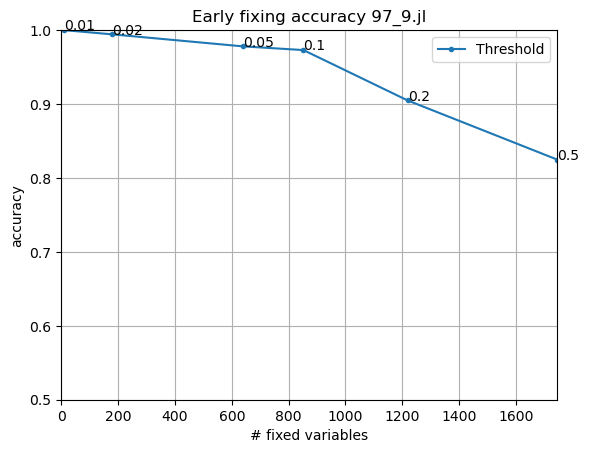

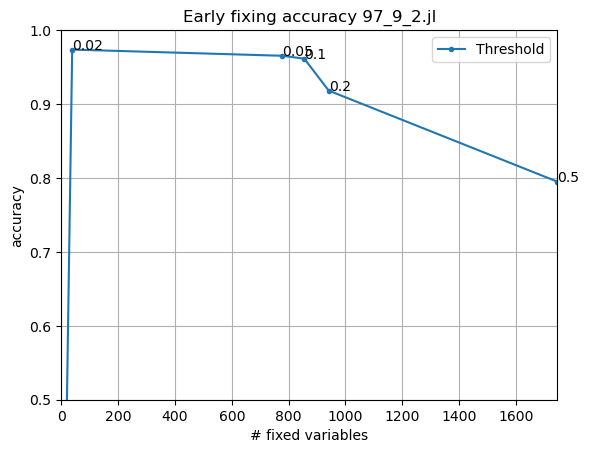

In [43]:
def get_ef_accuracy(g_batch, xs, x_opt, name=None, plot=True):
    with torch.no_grad():
        y_hat = torch.sigmoid(net(g_batch))

    y_flip = 1 - y_hat
    x_hat = (xs - y_flip).abs()  # prob. of the predicted optimal solution
    err = (x_hat - x_opt).abs()

    thresholds = [.01, .02, .05, .1, .2, .5]

    accs = list()
    ns = list()
    for thresh in thresholds:
        most_certain = (x_hat.mean(0) < thresh) | (x_hat.mean(0) >= 1 - thresh)
        if most_certain.sum() == 0:
            accs.append(0)
            ns.append(0)
            continue
        fixed_x_hat = (x_hat.mean(0)[most_certain] > .5).to(x_opt)
        fixed_x_opt = x_opt[most_certain]

        acc = (fixed_x_hat == fixed_x_opt).sum() / fixed_x_opt.shape[0]

        accs.append(acc)
        ns.append(fixed_x_hat.shape[0])

    if plot:
        fig, ax = plt.subplots()
        ax.plot(ns, accs, '.-', label='Threshold')
        ax.set_xlim((0, x_opt.shape[0]))
        ax.set_ylim((.5, 1.))
        ax.grid()
        ax.legend()

        ax.set_title('Early fixing accuracy '+str(name))
        ax.set_xlabel('# fixed variables')
        ax.set_ylabel('accuracy')

        for i, thresh in enumerate(thresholds):
            ax.annotate(thresh, (ns[i], accs[i]))

        fig.show()
    
    return thresholds, ns, accs

_, n1s, acc1s = get_ef_accuracy(g1_batch, x1s, x1_opt, name=instances[0].name)
print(n1s, acc1s)
_, n2s, acc2s = get_ef_accuracy(g2_batch, x2s, x2_opt, name=instances[1].name)
print(n2s, acc2s)